TODO: use more modern techniques to speed up training: `torch.compile`, `transform.v2`.

# Yolo v1 using minai
> Supercharge yolo v1 with miniai power

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastcore.all as fc

from functools import partial
from collections import Counter

from minai import *
from pilus_project.core import *
from pilus_project.yolov1 import *

In [ ]:
set_seed(42)

In [ ]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])
IMG_DIR = "../data/images"
LABEL_DIR = "../data/labels"

bs = 64

In [ ]:
!ls ..

8examples.csv	   _proc	    pilus_project	    test.csv
8examples_val.csv  data		    pilus_project.egg-info  train.all.txt
LICENSE		   generate_csv.py  pyproject.toml	    train.csv
MANIFEST.in	   nbs		    settings.ini	    voc_dataset.sh
README.md	   old_txt_files    setup.py		    voc_label.py


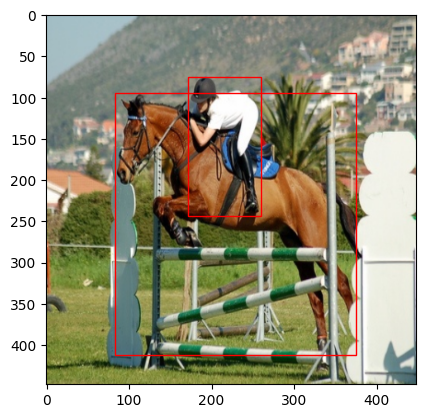

In [ ]:
trn_ds = VOCDataset("../train.csv", 
                    transform=transform,
                    img_dir=IMG_DIR,
                    label_dir=LABEL_DIR)
x0, y0 = trn_ds[0]
plot_image(x0, y0)

In [ ]:
# examples_val_8 = pd.read_csv("../test.csv").iloc[:8]
# examples_val_8

In [ ]:
# examples_val_8.to_csv('../8examples_val.csv', index=False)

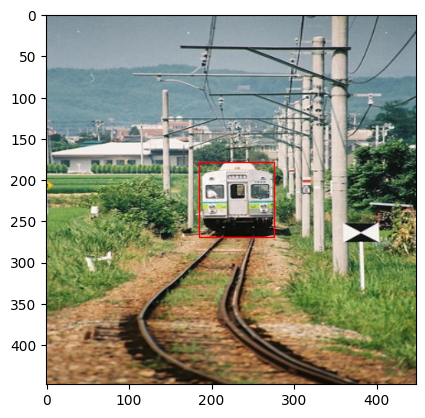

In [ ]:
val_ds = VOCDataset(
    "../test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)
x0, y0 = val_ds[0]
plot_image(x0, cellboxes_to_boxes(y0.unsqueeze(0))[0])

In [ ]:
len(trn_ds), len(val_ds)

(16550, 4951)

In [ ]:
trn_dl, val_dl = get_dls(trn_ds, val_ds, bs)
xb, yb = next(iter(trn_dl))
xb.shape, yb.shape

(torch.Size([64, 3, 448, 448]), torch.Size([64, 7, 7, 30]))

In [ ]:
dls = DataLoaders(trn_dl, val_dl)

In [ ]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 4096),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (C + B * 5)),
        )

## Learner 

In [ ]:
class MeanAP:
    def __init__(self, num_classes=1, epsilon=1e-6, threshold=0.4, iou_threshold=0.5, box_format='midpoint'):
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        self.box_format = box_format
        self.average_precisions = []
    
    def reset(self):
        self.average_precisions = []
    
    def compute(self):
        return sum(self.average_precisions) / len(self.average_precisions)
    
    def update(self, pred, label):
        # `get_bboxes` part
        all_pred_boxes = []
        all_true_boxes = []
        train_idx = 0
        batch_size = pred.shape[0]
        pred_boxes = cellboxes_to_boxes(pred)
        true_boxes = cellboxes_to_boxes(label)
        
        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                pred_boxes[idx],
                iou_threshold=self.iou_threshold,
                threshold=self.threshold,
                box_format=self.box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_boxes[idx]:
                # many will get converted to 0 pred
                if box[1] > self.threshold:
                    all_true_boxes.append([train_idx] + box)
        
        pred_boxes = all_pred_boxes
        true_boxes = all_true_boxes
        
        for c in range(self.num_classes):
            detections = []
            ground_truths = []

            # Go through all predictions and targets,
            # and only add the ones that belong to the
            # current class c
            for detection in pred_boxes:
                if detection[1] == c:
                    detections.append(detection)

            for true_box in true_boxes:
                if true_box[1] == c:
                    ground_truths.append(true_box)

            # find the amount of bboxes for each training example
            # Counter here finds how many ground truth bboxes we get
            # for each training example, so let's say img 0 has 3,
            # img 1 has 5 then we will obtain a dictionary with:
            # amount_bboxes = {0:3, 1:5}
            amount_bboxes = Counter([gt[0] for gt in ground_truths])

            # We then go through each key, val in this dictionary
            # and convert to the following (w.r.t same example):
            # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
            for key, val in amount_bboxes.items():
                amount_bboxes[key] = torch.zeros(val)

            # sort by box probabilities which is index 2
            detections.sort(key=lambda x: x[2], reverse=True)
            TP = torch.zeros((len(detections)))
            FP = torch.zeros((len(detections)))
            total_true_bboxes = len(ground_truths)

            # If none exists for this class then we can safely skip
            if total_true_bboxes == 0:
                continue

            for detection_idx, detection in enumerate(detections):
                # Only take out the ground_truths that have the same
                # training idx as detection
                ground_truth_img = [
                    bbox for bbox in ground_truths if bbox[0] == detection[0]
                ]

                num_gts = len(ground_truth_img)
                best_iou = 0

                for idx, gt in enumerate(ground_truth_img):
                    iou = intersection_over_union(
                        torch.tensor(detection[3:]),
                        torch.tensor(gt[3:]),
                        box_format=self.box_format,
                    )

                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = idx

                if best_iou > self.iou_threshold:
                    # only detect ground truth detection once
                    if amount_bboxes[detection[0]][best_gt_idx] == 0:
                        # true positive and add this bounding box to seen
                        TP[detection_idx] = 1
                        amount_bboxes[detection[0]][best_gt_idx] = 1
                    else:
                        FP[detection_idx] = 1

                # if IOU is lower then the detection is a false positive
                else:
                    FP[detection_idx] = 1

            TP_cumsum = torch.cumsum(TP, dim=0)
            FP_cumsum = torch.cumsum(FP, dim=0)
            recalls = TP_cumsum / (total_true_bboxes + self.epsilon)
            precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + self.epsilon))
            precisions = torch.cat((torch.tensor([1]), precisions))
            recalls = torch.cat((torch.tensor([0]), recalls))
            # torch.trapz for numerical integration
            self.average_precisions.append(torch.trapz(precisions, recalls))

In [ ]:
cbs = [
    TrainCB(),
    DeviceCB(),
    MetricsCB(MeanAP(num_classes=20)),
]
opt = partial(torch.optim.AdamW, betas=(0.9,0.95), eps=1e-5)

In [ ]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20)

lr, epochs = 1e-6, 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

learn = Learner(model, dls, YoloLoss(), lr=lr, cbs=cbs+xtra, opt_func=torch.optim.AdamW)

`learn.show_image_batch` needs to be fixed.

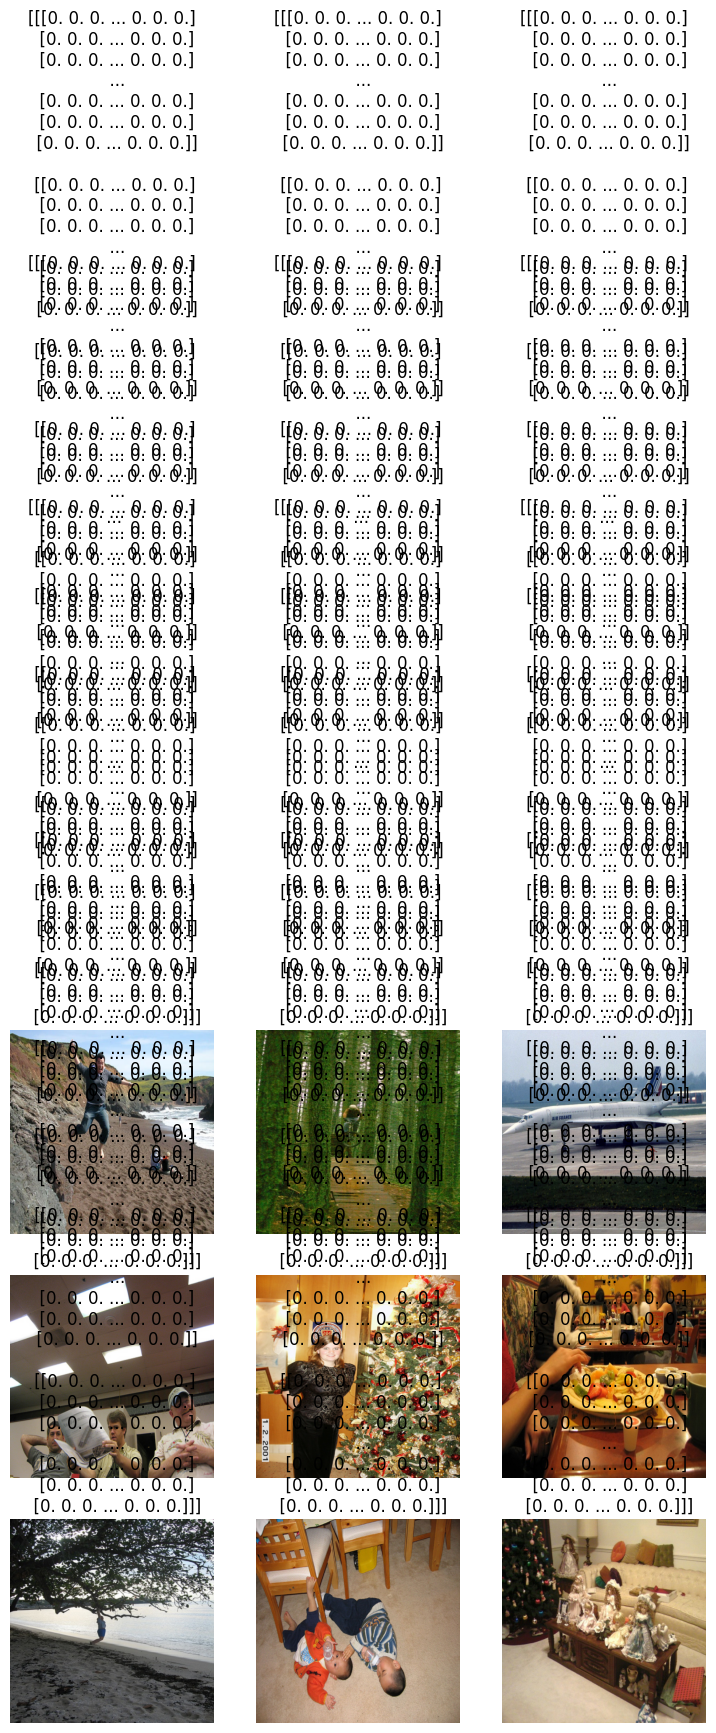

In [ ]:
learn.show_image_batch()

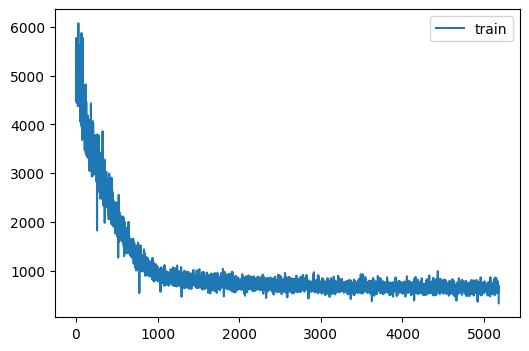

In [ ]:
learn.fit(epochs, cbs=[ProgressCB(plot=True)])

## Testing

Let's see if the model learned about bounding boxes for the training set.

Loading the weight from previous one:

In [ ]:
# learn.opt_func = torch.optim.Adam(
#     learn.model.parameters(), lr=lr, weight_decay=0
# )

load_checkpoint(torch.load("yolov1_1e-6_20.pth.tar", map_location=torch.device('cpu'), weights_only=True),
                learn.model, learn.opt)

=> Loading checkpoint


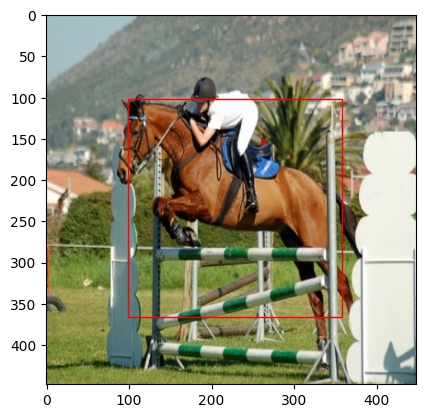

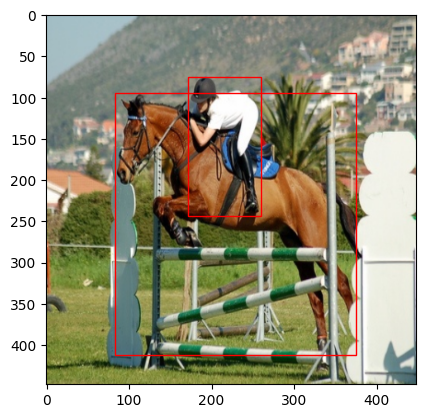

TypeError: Image data of dtype object cannot be converted to float

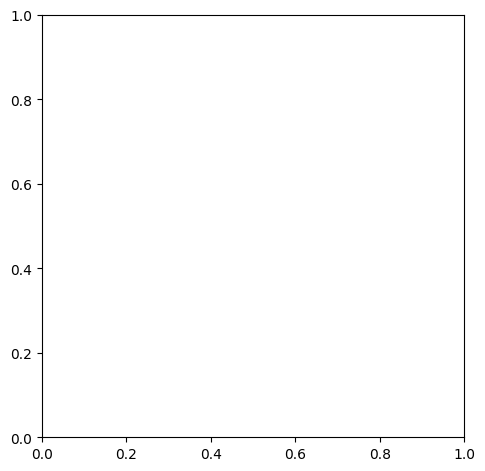

In [ ]:
learn.model.train(False)
for i in range(8):
    x0, y0 = trn_ds[i]
    bboxes = cellboxes_to_boxes(learn.model(x0.unsqueeze(0).to(DEVICE)))
    bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format='midpoint')
    
    compare_ims(plot_image(x0, bboxes), plot_image(x0, cellboxes_to_boxes(y0.unsqueeze(0))[0]))

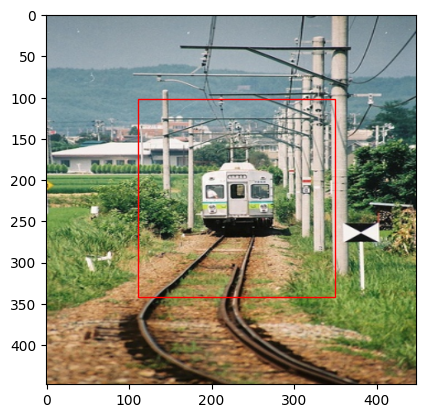

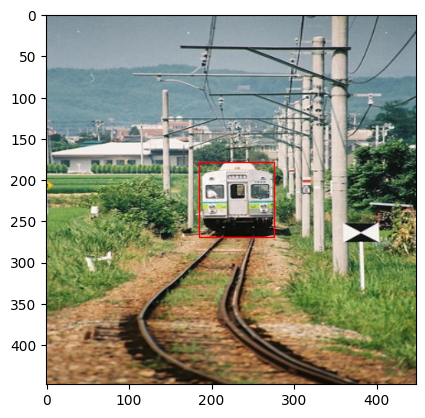

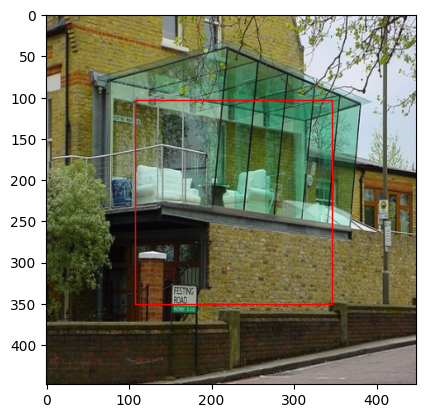

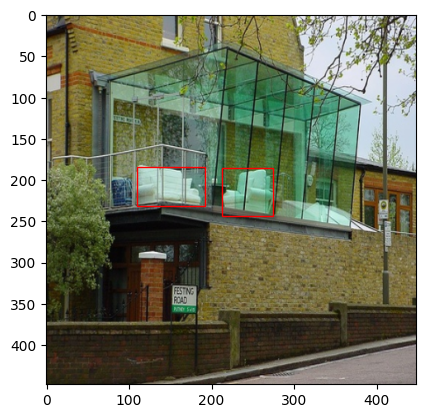

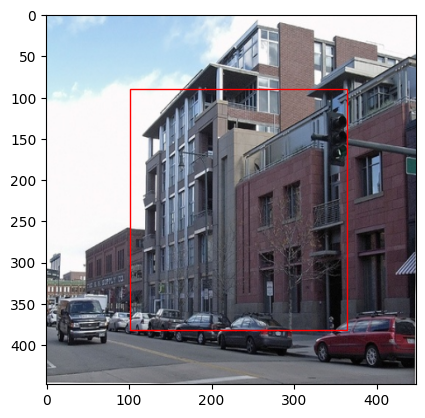

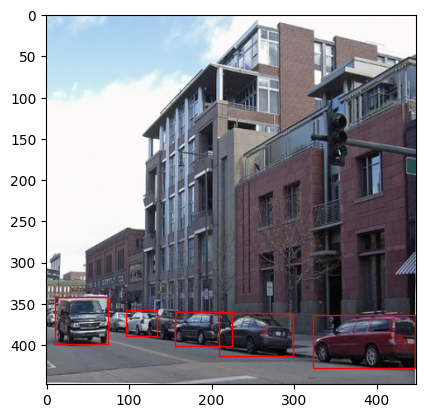

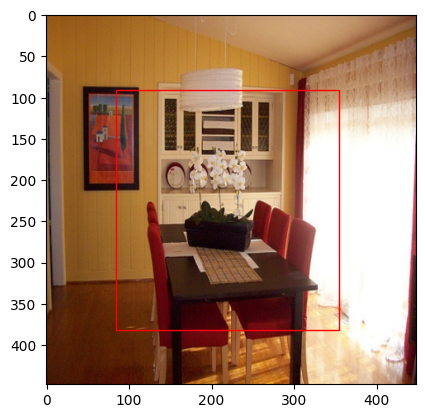

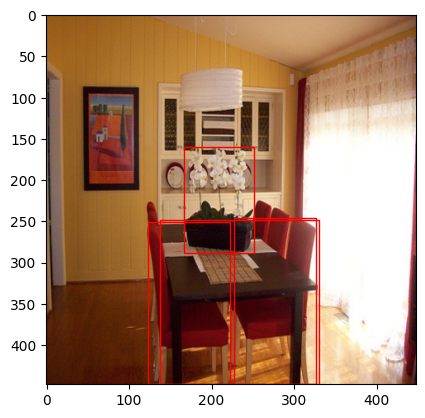

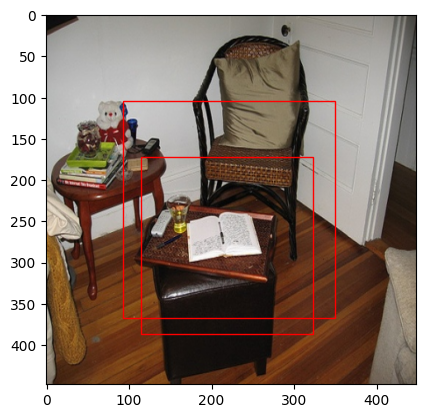

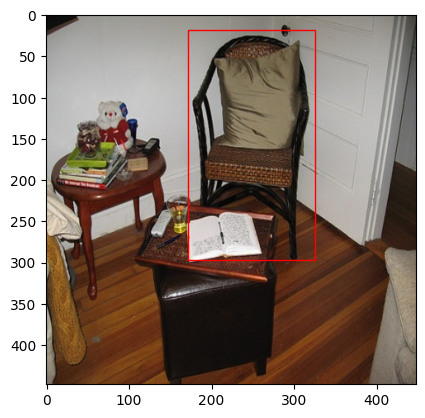

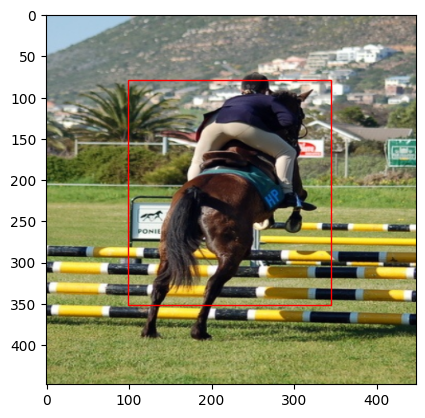

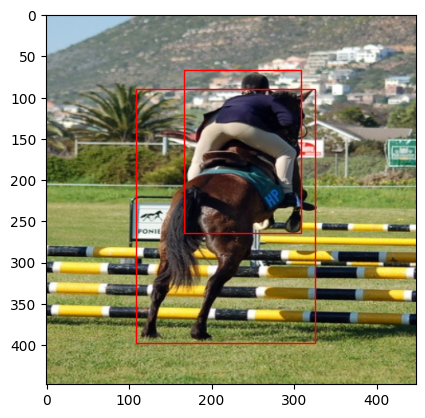

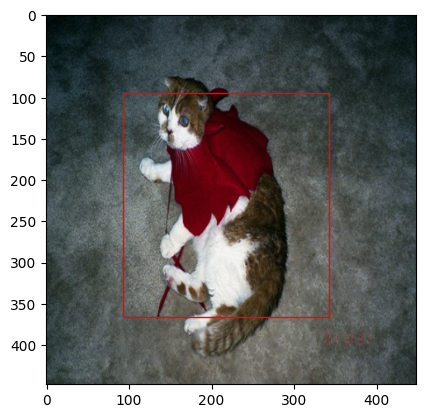

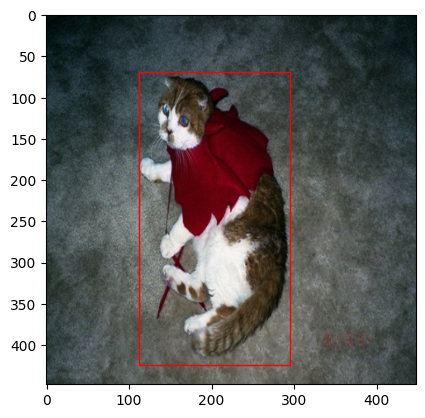

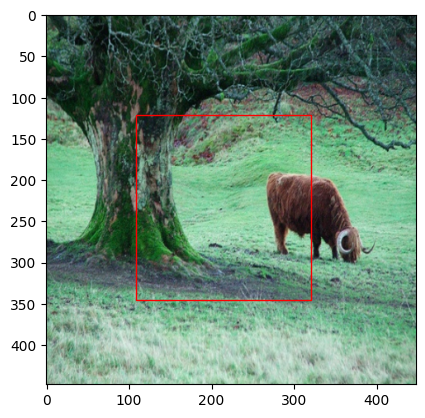

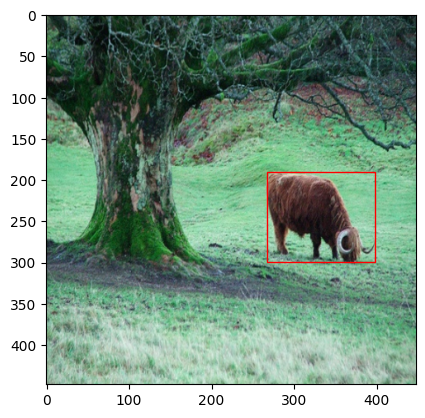

In [ ]:
learn.model.train(False)
for i in range(8):
    x0, y0 = val_ds[i]
    bboxes = cellboxes_to_boxes(learn.model(x0.unsqueeze(0).to(DEVICE)))
    bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format='midpoint')
    plot_image(x0, bboxes)
    plot_image(x0, cellboxes_to_boxes(y0.unsqueeze(0))[0])

That doesn't look that bad! Let's save the model states.

In [ ]:
checkpoint = {
   "state_dict": learn.model.state_dict(),
   "optimizer": learn.opt.state_dict(),
}
torch.save(checkpoint, "yolov1_1e-6_20.pth.tar")